pyHSMM-MVPA
==========

pyHSMM-MVPA is an open-source Python package to estimate Hidden Semi-Markov Models in a Multivariate Pattern Analysis of electro-encephalographic data based on the method developed by Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) and Borst & Anderson ([2021](http://jelmerborst.nl/pubs/ACTR_HsMM_MVPA_BorstAnderson_preprint.pdf))


# Documentation

The package will be soon available through *pip*, in the meantime, to install pyhsmm-mvpa you can clone the repository using *git*

Open a terminal and type:

    $ git clone https://github.com/gweindel/pyhsmm-mvpa.git
   
Then install the required dependencies:

- Python >= 3.7
- NumPy >= 1.18.1
- MNE >= 1.0
- Matplotlib >= 3.1.0
- xarray >= 2022.6.0

A recommended way of installing these dependency is to use a new conda environment (see [anaconda](https://www.anaconda.com/products/distribution>) for how to install conda):

    $ conda create -n pyhsmm xarray mne 
    $ conda activate pyhsmm

Then naviguate to the cloned repository and import pyhsmm-mvpa in your favorite python IDE through:

```python
    import pyhsmm_mvpa as hsmm
```

## Demo on simulated data

The following section will quickly walk you through an example usage in simulated data


First we load the libraries necessary for the demo on simulated data

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from mne import channels

## Importing 
import hsmm_mvpy as hsmm
from hsmm_mvpy import simulations

### Simulating data

In the following code block we simulate 30 trials from four known sources. All these four sources are defined by a localization, an activation amplitude and a distribution (here gamma wuth shape and scale parameters) for the onsets of the bumps on each trial. The simulation functions are based on the [MNE tutorial ](https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html).


In [2]:
cpus = 16 # For multiprocessing, usually a good idea to use multiple CPus as long as you have enough RAM
path = 'simulated/'#Wehre simulated data will go, vreate that folder if you don't have it where you're executing the code

n_events = 30 #Number of trials to simulate

sources = [['lateraloccipital-lh',1e-8, [np.random.gamma,2,30]],#One source = localization, acitvation amplitude and onset latencies
           ['postcentral-lh', 1e-8, [np.random.gamma, 2, 50]],
           ['posteriorcingulate-rh', 1e-8, [np.random.gamma, 2,40]],
           ['postcentral-rh', 1e-8, [np.random.gamma, 2,100]],
           ['postcentral-lh', 1e-10, [np.random.gamma, 2,75]]] #Equivalent to a response trigger as amplitude make it hardly visible

max_trial_length = 3000 #length of a trial (ISI)

bump_frequency = 10. #Frequency of the simulated bumps
file = 'dataset_tutorial' #Name of the file to save
mne_path = path+file+'_raw.fif'

raw, generating_events = simulations.simulate(sources, n_events, max_trial_length, cpus, bump_frequency, file, path, overwrite=True)

Aligning file name to MNE's convention
Simulating dataset_tutorial_raw.fif in simulated/


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

Overwriting existing file.
Writing /home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/simulated/dataset_tutorial_raw.fif
Closing /home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/simulated/dataset_tutorial_raw.fif
[done]
simulated/dataset_tutorial_raw.fif simulated


### Creating the event structure and plotting the raw data


To recover the data we need to create the event structure based on the triggers sent during simulation. This is the same as analyzing real EEG data and recovering events in the stimulus channel. In our case 0 signal the onset of the stimulus and 5 the onset of the response. Hence a trial is defined as the times occuring between the triggers 0 and 5.

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Using matplotlib as 2D backend.


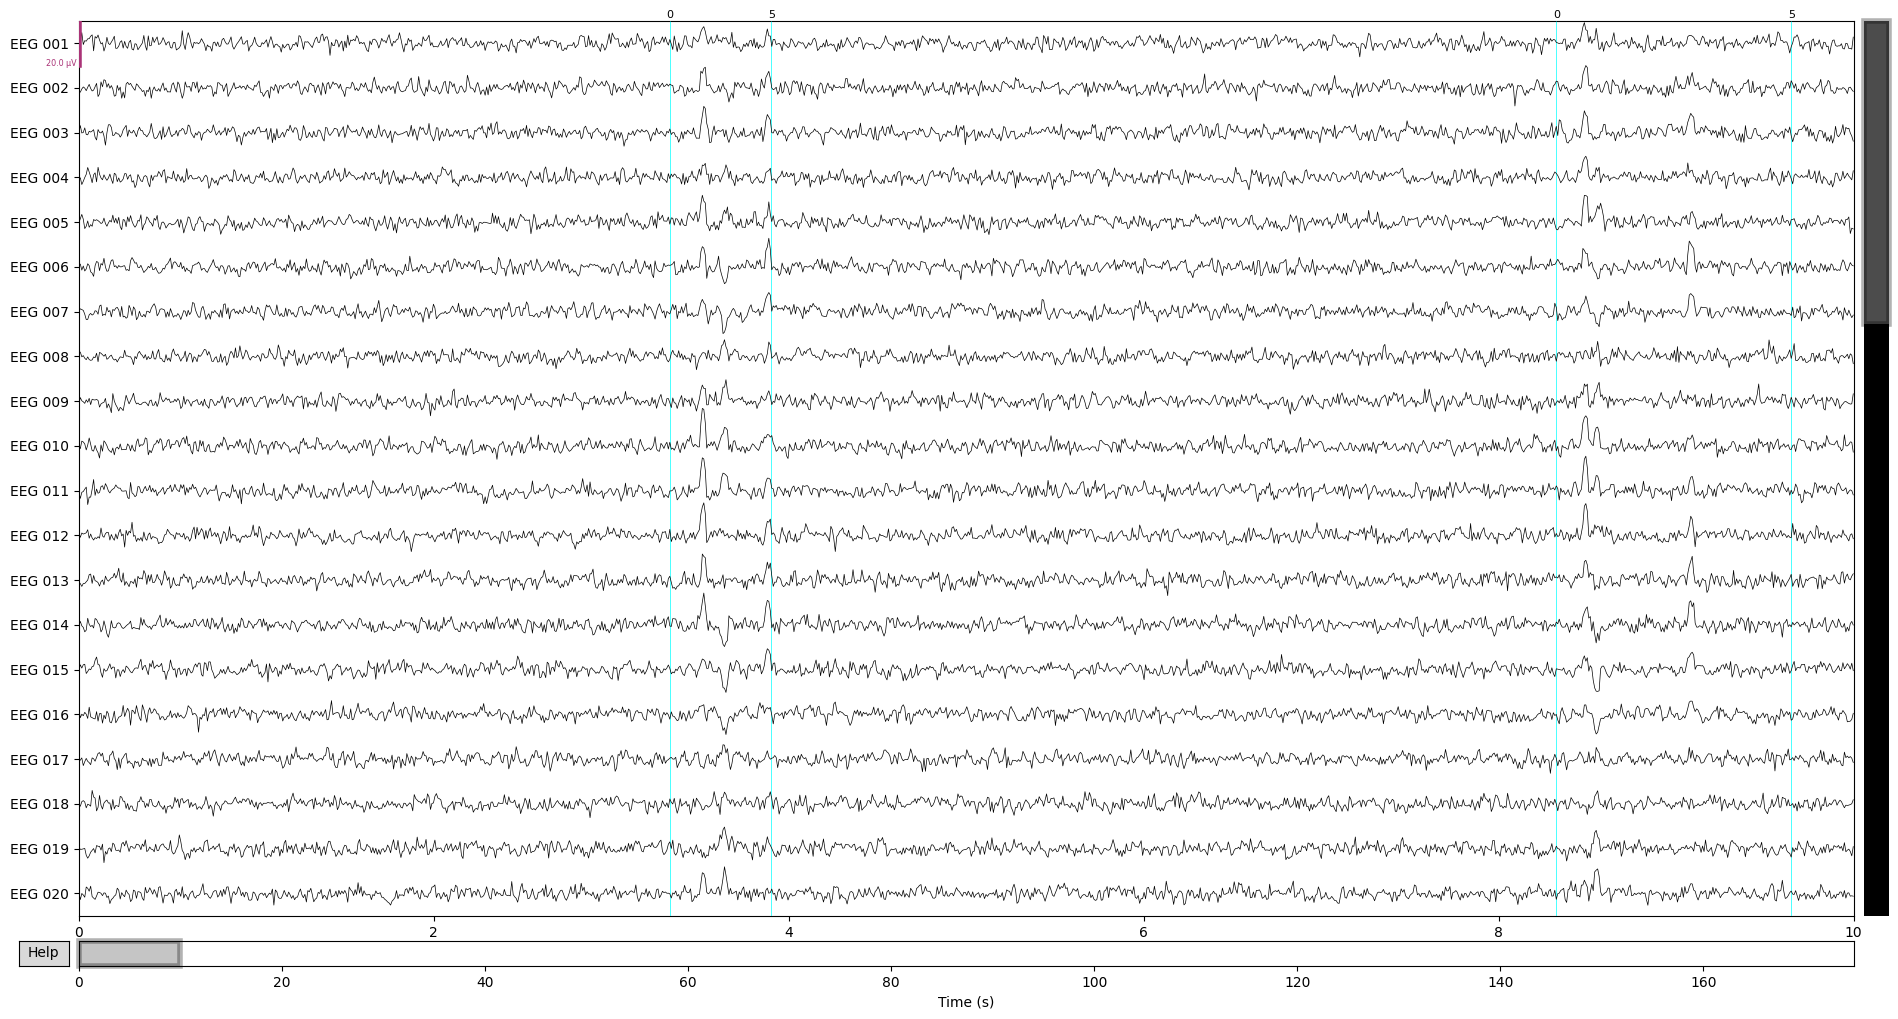

In [3]:
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':0}
resp_id = {'response':resp_trigger}
events = generating_events[(generating_events[:,2] == 0) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

raw.copy().pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events);

### Recovering number of sources as well as actual by-trial variation

To compare the by-trial duration of bumps that we will estimate later on we first recover the actual number of sources used in the simulation as well as the actual by-trial variation in the onset of the bumps.

In [4]:
%matplotlib inline
number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

i,x = 1,0                  
while x < len(random_source_times):
    for j in np.arange(number_of_sources):#recovering the individual duration- of bump onset
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

## Demo of the HsMM Code for a single participant in a single condition based on the simulated data

First we read the EEG data as we would for a single participant:

In [5]:
# Reading the data
eeg_dat = hsmm.utils.read_mne_EEG(mne_path, event_id, resp_id, raw.info['sfreq'],events, verbose=False)


Processing participant simulated/dataset_tutorial_raw.fif
Reading 0 ... 104999  =      0.000 ...   174.819 secs...
N trials without response event: 0
Applying reaction time trim to keep RTs between 0.001 and 5 seconds
30 trials were retained for participant simulated/dataset_tutorial_raw.fif
End sampling frequency is 600.614990234375


The package uses [xarray](https://docs.xarray.dev/en/stable/) named dimension matrices, allowing to directly manipulate the data using the name of the dimensions:

<xarray.Dataset>
Dimensions:     (participant: 1, epochs: 30, electrodes: 59, samples: 1093)
Coordinates:
  * epochs      (epochs) int64 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * electrodes  (electrodes) <U7 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples     (samples) int64 0 1 2 3 4 5 6 ... 1087 1088 1089 1090 1091 1092
Dimensions without coordinates: participant
Data variables:
    data        (participant, epochs, electrodes, samples) float64 -3.374e-07...
    event       (participant, epochs) <U8 'stimulus' 'stimulus' ... 'stimulus'
Attributes:
    sfreq:    600.614990234375


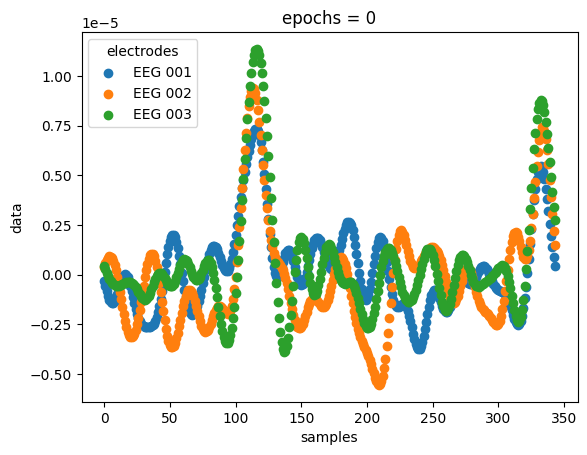

In [6]:
#example of usage of xarray
print(eeg_dat)
eeg_dat.sel(epochs=0,electrodes=['EEG 001','EEG 002','EEG 003']).plot.scatter(x='samples', y='data',hue='electrodes');

Next we transform the data as in Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) including standardization of individual variances (not in this case as we have only one simulated participant), z-scoring and spatial principal components analysis (PCA). 

Note that if the number of components to retain is not specified, the scree plot of the PCA is displayed and a prompt ask how many PCs should be retained 

In [7]:
hsmm_dat, PCs, explained_var, means = hsmm.utils.transform_data(eeg_dat.data,'',
        apply_standard=False, single=True, n_comp=10, return_weights=True)

hsmm_dat = hsmm.utils.stack_data(hsmm_dat,'',single=True)

# Estimating an HsMM model

We know that we generate from four sources so let's just try to recover those four sources by directly estimating a 4 bump model. 

In [8]:
init = hsmm.models.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50, cpus=16)#Initialization of the model

selected = init.fit_single(number_of_sources-1, starting_points=25)#function to fit an instance of a 4 bumps model with 25 random starting points for the expectation maximization algorithm

Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model


### Visualizing results of the fit

In [9]:
bump_times_selected = init.bump_times(selected.eventprobs)#computing predicted bump times
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes_selected = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)#reconstructing electrode activity

We can directly take a look to the topologies and latencies of the bumps by calling ```hsmm.visu.plot_topo_timecourse```

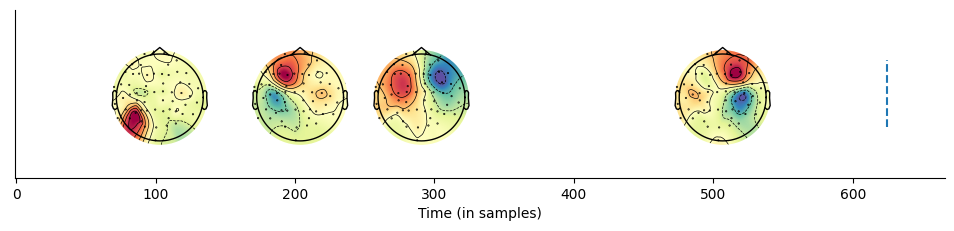

In [10]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

And take a closer look to stages and their by-trial variation

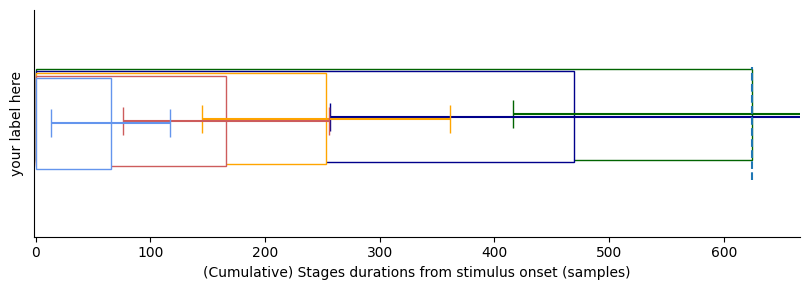

In [11]:
ax = hsmm.visu.plot_latencies_average(bump_times_selected, init.bump_width_samples, 1, errs='std', times_to_display = np.mean(init.ends - init.starts))
ax.set_ylabel('your label here');

And inspect the probability distribution of bump onsets:

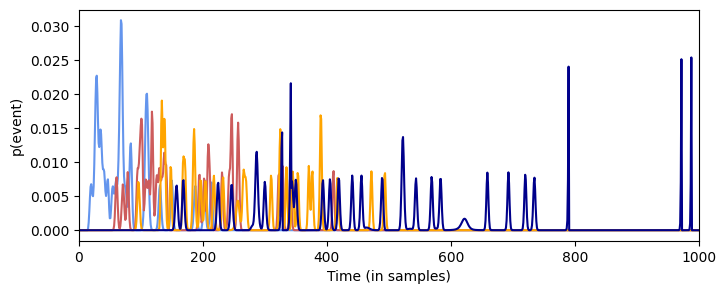

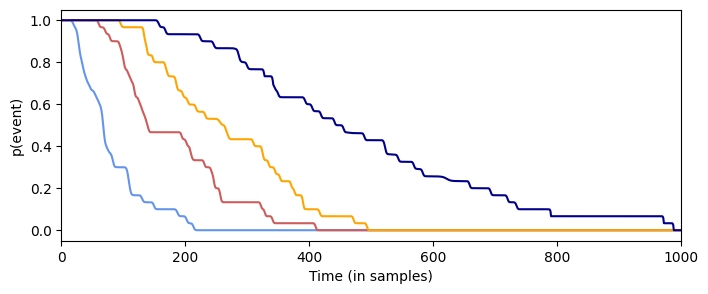

In [12]:
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial']), xlims=(0,1000))
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial']), xlims=(0,1000), survival=True);

As HsMM-MVPA selected those bumps onset per trial we can also look at the predicted bump onsets for a single trial

<AxesSubplot:xlabel='Time (in samples)', ylabel='p(event)'>

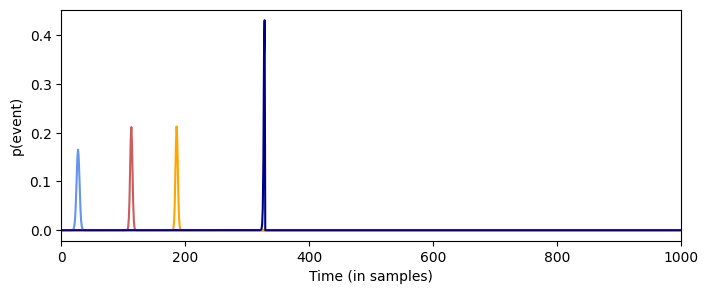

In [13]:
hsmm.visu.plot_distribution(selected.eventprobs.sel(trial=0), xlims=(0,1000))

## Comparing with ground truth

Now as we simulated the data we have access to the ground truth of the underlying generative events. We can then compare the average stage durations compared to the one estimated by HsMM-MVPA

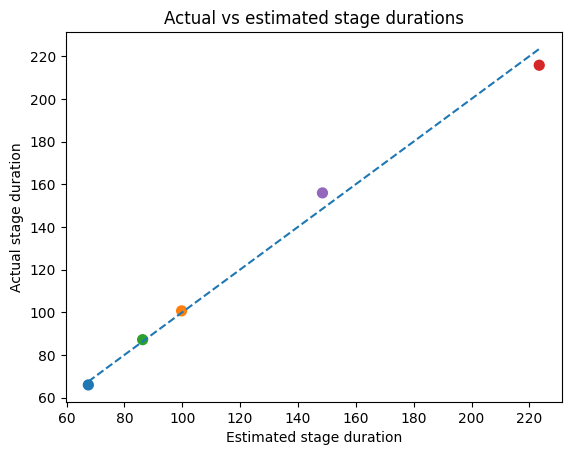

In [14]:
colors = sns.color_palette(None, number_of_sources)
plt.scatter(np.mean(random_source_times, axis=0), selected.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()


Or also overlay actual bumps onset with predicted one

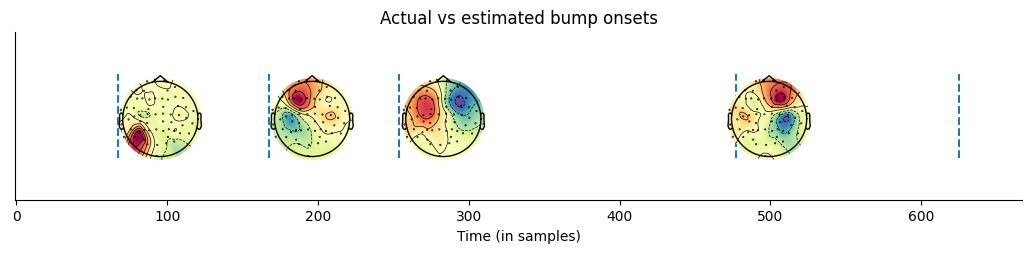

In [15]:
positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, np.mean(init.bump_times(selected.eventprobs), axis=0), positions,#inferring electrode location, 
        bump_size=init.bump_width_samples, time_step = 1, magnify=4, figsize=(13,2), title='Actual vs estimated bump onsets',
        times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

And even compare single trial onsets with those estimated from the HsMM model

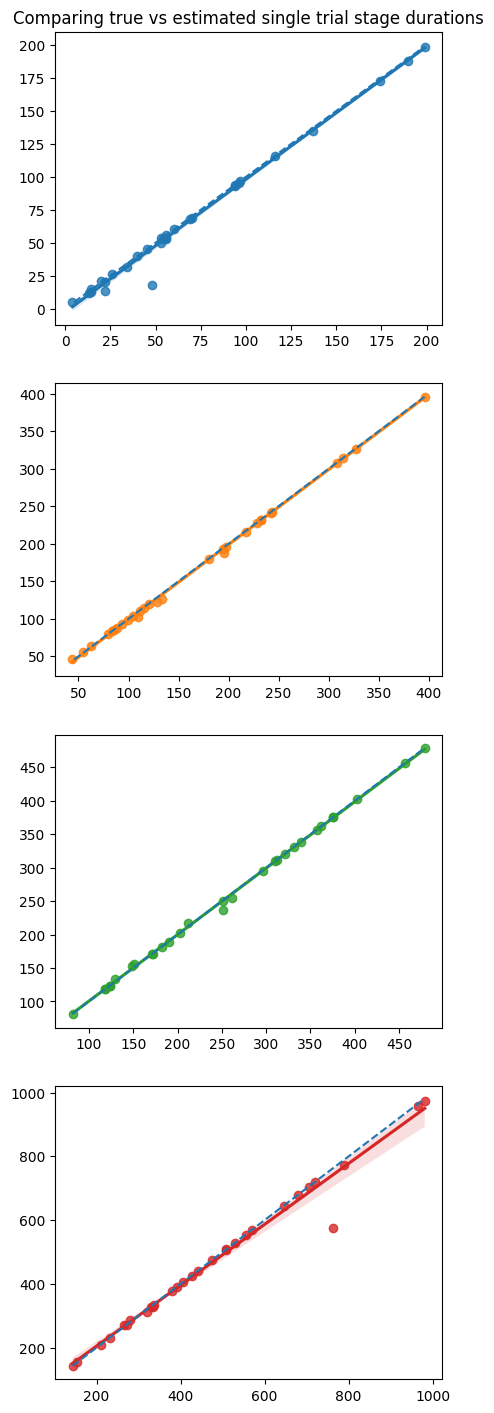

In [16]:

fig, ax= plt.subplots(number_of_sources-1,1, figsize=(5,3.5*number_of_sources))
ax[0].set_title('Comparing true vs estimated single trial stage durations')
i = 0
gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
for bump in init.bump_times(selected.eventprobs)[:,:number_of_sources-1].T:
    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
    i+= 1

For examples on how to use the package when the number of bumps are unkown, or to compare stage durations across conditions see the example notebooks